In [1]:
# ! pip install hazm
# ! pip install gensim
# ! pip -q install clean-text[gpl]
# ! pip3 install transformers
# ! uname -a

In [2]:
import pandas as pd
import numpy as np
import re
from __future__ import unicode_literals
import hazm
import nltk
import codecs
import tqdm
import gensim
from cleantext import clean

### Plot utils

In [82]:
# ! pip install arabic_reshaper
# ! pip install python-bidi
# ! pip install seaborn

In [84]:
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import seaborn as sns

In [85]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [104]:
def make_farsi_text(x):
    if x == 'الله':
        return 'هللا'
    reshaped_text = reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

### Load Data

In [4]:
with open('masnavi.txt', 'r', encoding="utf8") as infile:
    masnavi_file = infile.readlines()

In [5]:
stopwords = [x.strip() for x in codecs.open('stopwords.txt','r','utf-8').readlines()]

In [6]:
persian_punctuation = ['،','؟',':','\*','«',"»"]

In [7]:
normalizer = hazm.Normalizer()

In [8]:
lemmatizer = hazm.Lemmatizer()

In [9]:
# Store Masnavi
masnavi = []

In [10]:
def clean_arabic(text):
    text = re.sub("[إأا]", "ا", text)
    text = re.sub("ي", "ی", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ۀ", "ه", text)
    text = re.sub("ك", "گ", text)
    return text

In [11]:
def clean_text(text, tokenize = False):
    text = normalizer.normalize(text)
    text = lemmatizer.lemmatize(text)
    text = re.sub(r"|".join(persian_punctuation), " ", text)
    regex = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
    text = re.sub(regex, " ", text)
    text = clean_arabic(text)
    text = re.sub(u"\u200c" , "", text)
    text = re.sub(r'\s+', " ", text)
    text = text.strip()
    return text

In [12]:
def process_couplet(text):
    result = re.search("(\d{1,3})\.(\d{1,3})", text)
    # check if line contains a couplet
    if result:
        pno, cno = result.groups()
        # delete Daftar and Poem number
        couplet = re.sub("(\d{1,3})\.(\d{1,3})", "", text)
        # extract mesra
        hemistich = couplet.split("\t")[1:3]
        # clean mesra
        cleaned_hemistich = [clean_text(h) for h in hemistich]
        return pno, cno, "\t".join(hemistich), " ".join(cleaned_hemistich), cleaned_hemistich[0], cleaned_hemistich[1]
    return None

In [13]:
daftar = 0
for couplet in masnavi_file:
    if re.search("^(?:دفتر).*.(?:مثنوی)$", couplet):
        daftar += 1
        if daftar == 7:
            print("Processing Completed!")
            break
        print(f"Processing Daftar {daftar}")
    else:
        process_result = process_couplet(couplet)
        if process_result:
            pno = process_result[0]
            cno = process_result[1]
            c = process_result[2]
            cc = process_result[3]
            h1 = process_result[4]
            h2 = process_result[5]
            masnavi.append((daftar, pno, cno, c, cc, h1, h2))

Processing Daftar 1
Processing Daftar 2
Processing Daftar 3
Processing Daftar 4
Processing Daftar 5
Processing Daftar 6


In [14]:
masnavi_df = pd.DataFrame(masnavi, columns=['Daftar', 'Poem', 'CNo', 'Couplet', 'CCouplet', 'Hemistich1', 'Hemistich2'])

In [15]:
masnavi_df.Hemistich2[300:350]

300             سگی دراننده شاه
301                 نیک نیک نما
302              درستی شکست خضر
303                   محجوب مپر
304         مست عقل مجنونش مدان
305                 کافرم بردمی
306              گمان مدحش متقی
307                   خاصه الله
308                تخت جاهی کشد
309    شرع میدارد روا بگذار کام
310                  وهمت نیاید
311             لطف مطلق قهر جو
312        مادر مشفق غم شاد کام
313             افتاده بنگر نیک
314                بو بیانم حصه
315               نوا سبز طوطیی
316               نکته سوداگران
317        نوای طوطیان حاذق بدی
318      دکان طوطی نگهبانی نمود
319          موشی طوطیک بیم جان
320          شیشه روغن گل بریخت
321    دکان بنشست فارغ خواجه وش
322                سرش طوطی ضرب
323           مرد بقال ندامت آه
324            کافتاب نعمتم میغ
325                    زدم زبان
326                     نطق مرغ
327        دکان بنشسته نومیدوار
328                کای مرغ بگفت
329          تعجب بدندان میگرفت
330                   کاندر سخن
331     

### Process dataframe data types

In [16]:
masnavi_df['Daftar'] = masnavi_df['Daftar'].apply(pd.to_numeric)
masnavi_df['Poem'] = masnavi_df['Poem'].apply(pd.to_numeric)
masnavi_df['CNo'] = masnavi_df['CNo'].apply(pd.to_numeric)

In [17]:
masnavi_df[masnavi_df['Daftar']==1]

,Daftar,Poem,CNo,Couplet,CCouplet,Hemistich1,Hemistich2
0,1,1,1,بشنو از نی، چون حكایت میكند\tواز جدائی ها شكای...,بشنو نی جدائی شکایت,بشنو نی,جدائی شکایت
1,1,1,2,کز نیستان تا مرا ببریده اند\tاز نفیرم مرد و زن...,نیستان ببریده نفیرم مرد زن نالیده,نیستان ببریده,نفیرم مرد زن نالیده
2,1,1,3,سینه خواهم شرحه شرحه از فراق\tتا بگویم شرح درد...,سینه شرحه شرحه فراق شرح درد اشتیاق,سینه شرحه شرحه فراق,شرح درد اشتیاق
3,1,1,4,هر كسی كاو دور ماند از اصل ِ خویش\tباز جوید رو...,اصل جوید روزگار وصل,اصل,جوید روزگار وصل
4,1,1,5,من به هر جمعیتی نالان شدم\tجفت بَد حالان و خوش...,جمعیتی نالان جفت حالان حالان,جمعیتی نالان,جفت حالان حالان
...,...,...,...,...,...,...,...
4530,1,182,10,بر همان بو می خوری این خشك را\tبعد از آن كامیخ...,بو خشک کامیخت معنی ثری,بو خشک,کامیخت معنی ثری
4531,1,182,11,گشت خاك آمیز و خشك و گوشت بُر\tز آن گیاه اكنون...,خاک آمیز خشک گوشت گیاه بپرهیز شتر,خاک آمیز خشک گوشت,گیاه بپرهیز شتر
4532,1,182,12,سخت خاك آلود می آید سُخُن\tآب تیره شد، سر چه ب...,خاک آلود سخن آب تیره بند,خاک آلود سخن,آب تیره بند
4533,1,182,13,تا خدایش باز صاف و خوش كند\tآنكه تیره كرد هم ص...,خدایش صاف تیره صافش,خدایش صاف,تیره صافش


### Create Tokenized columns

In [18]:
masnavi_df['Couplet_tokenized'] = masnavi_df['CCouplet'].apply(lambda x:hazm.word_tokenize(x))

In [19]:
masnavi_df['Hemistich1_tokenized'] =  masnavi_df['Hemistich1'].apply(lambda x:hazm.word_tokenize(x))

In [20]:
masnavi_df['Hemistich2_tokenized'] =  masnavi_df['Hemistich2'].apply(lambda x:hazm.word_tokenize(x))

In [21]:
masnavi_df

,Daftar,Poem,CNo,Couplet,CCouplet,Hemistich1,Hemistich2,Couplet_tokenized,Hemistich1_tokenized,Hemistich2_tokenized
0,1,1,1,بشنو از نی، چون حكایت میكند\tواز جدائی ها شكای...,بشنو نی جدائی شکایت,بشنو نی,جدائی شکایت,"[بشنو, نی, جدائی, شکایت]","[بشنو, نی]","[جدائی, شکایت]"
1,1,1,2,کز نیستان تا مرا ببریده اند\tاز نفیرم مرد و زن...,نیستان ببریده نفیرم مرد زن نالیده,نیستان ببریده,نفیرم مرد زن نالیده,"[نیستان, ببریده, نفیرم, مرد, زن, نالیده]","[نیستان, ببریده]","[نفیرم, مرد, زن, نالیده]"
2,1,1,3,سینه خواهم شرحه شرحه از فراق\tتا بگویم شرح درد...,سینه شرحه شرحه فراق شرح درد اشتیاق,سینه شرحه شرحه فراق,شرح درد اشتیاق,"[سینه, شرحه, شرحه, فراق, شرح, درد, اشتیاق]","[سینه, شرحه, شرحه, فراق]","[شرح, درد, اشتیاق]"
3,1,1,4,هر كسی كاو دور ماند از اصل ِ خویش\tباز جوید رو...,اصل جوید روزگار وصل,اصل,جوید روزگار وصل,"[اصل, جوید, روزگار, وصل]",[اصل],"[جوید, روزگار, وصل]"
4,1,1,5,من به هر جمعیتی نالان شدم\tجفت بَد حالان و خوش...,جمعیتی نالان جفت حالان حالان,جمعیتی نالان,جفت حالان حالان,"[جمعیتی, نالان, جفت, حالان, حالان]","[جمعیتی, نالان]","[جفت, حالان, حالان]"
...,...,...,...,...,...,...,...,...,...,...
27948,6,145,49,قصه کوته کن، که رفتم در حجاب\tهین خمش والله اع...,قصه کوته رفتم حجاب هین خمش والله اعلم بالصواب,قصه کوته رفتم حجاب,هین خمش والله اعلم بالصواب,"[قصه, کوته, رفتم, حجاب, هین, خمش, والله, اعلم,...","[قصه, کوته, رفتم, حجاب]","[هین, خمش, والله, اعلم, بالصواب]"
27949,6,145,50,* شکر کاین نامه به عنوانی رسید\tگم نشد نقد و ب...,شکر نامه عنوانی گم نقد اخوانی,شکر نامه عنوانی,گم نقد اخوانی,"[شکر, نامه, عنوانی, گم, نقد, اخوانی]","[شکر, نامه, عنوانی]","[گم, نقد, اخوانی]"
27950,6,145,51,* نردبان آسمان است این کلام\tهر که از این بر ر...,نردبان آسمان کلام بام,نردبان آسمان کلام,بام,"[نردبان, آسمان, کلام, بام]","[نردبان, آسمان, کلام]",[بام]
27951,6,145,52,* نه به بام چرخ کان اخضر بود\tبل به بامی کز فل...,بام چرخ اخضر بل بامی فلک برتر,بام چرخ اخضر,بل بامی فلک برتر,"[بام, چرخ, اخضر, بل, بامی, فلک, برتر]","[بام, چرخ, اخضر]","[بل, بامی, فلک, برتر]"


### Frequency Analysis

In [22]:
from itertools import chain
from collections import Counter

In [23]:
all_words = list(chain.from_iterable(masnavi_df.Couplet_tokenized))

In [24]:
words_frequencies = nltk.FreqDist(all_words).most_common(100)

In [25]:
words_frequencies[:10]

[('جان', 1538),
 ('دل', 1047),
 ('آب', 941),
 ('نی', 911),
 ('دست', 776),
 ('چشم', 731),
 ('نور', 648),
 ('جهان', 602),
 ('عقل', 565),
 ('جمله', 549)]

In [26]:
print ('%-16s' % 'Number of words', '%-16s' % len(all_words))
print ('%-16s' % 'Number of unique words', '%-16s' % len(set(all_words)))
avg=np.sum([len(word) for word in all_words])/len(all_words)
print ('%-16s' % 'Average word length', '%-16s' % avg)
print ('%-16s' % 'Longest word', '%-16s' % all_words[np.argmax([len(word) for word in all_words])])

Number of words  165878          
Number of unique words 22249           
Average word length 3.993766503092634
Longest word     استخوانهاشان    


### TF/IDF Analysis

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt

In [125]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [126]:
tfidf = tfidf_vectorizer.fit_transform(all_words)

In [127]:
tfidf

<165878x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 151833 stored elements in Compressed Sparse Row format>

In [128]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [129]:
tf = tf_vectorizer.fit_transform(all_words)

In [145]:
nmf = NMF(
    n_components=10,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1,
    alpha_H=0.1,
    l1_ratio=0.5,
)

In [146]:
W = nmf.fit_transform(tfidf)

/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [147]:
H = nmf.components_

In [148]:
H.shape

(10, 10000)

In [149]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [150]:
tfidf_feature_names = [make_farsi_text(t) for t in tfidf_feature_names]

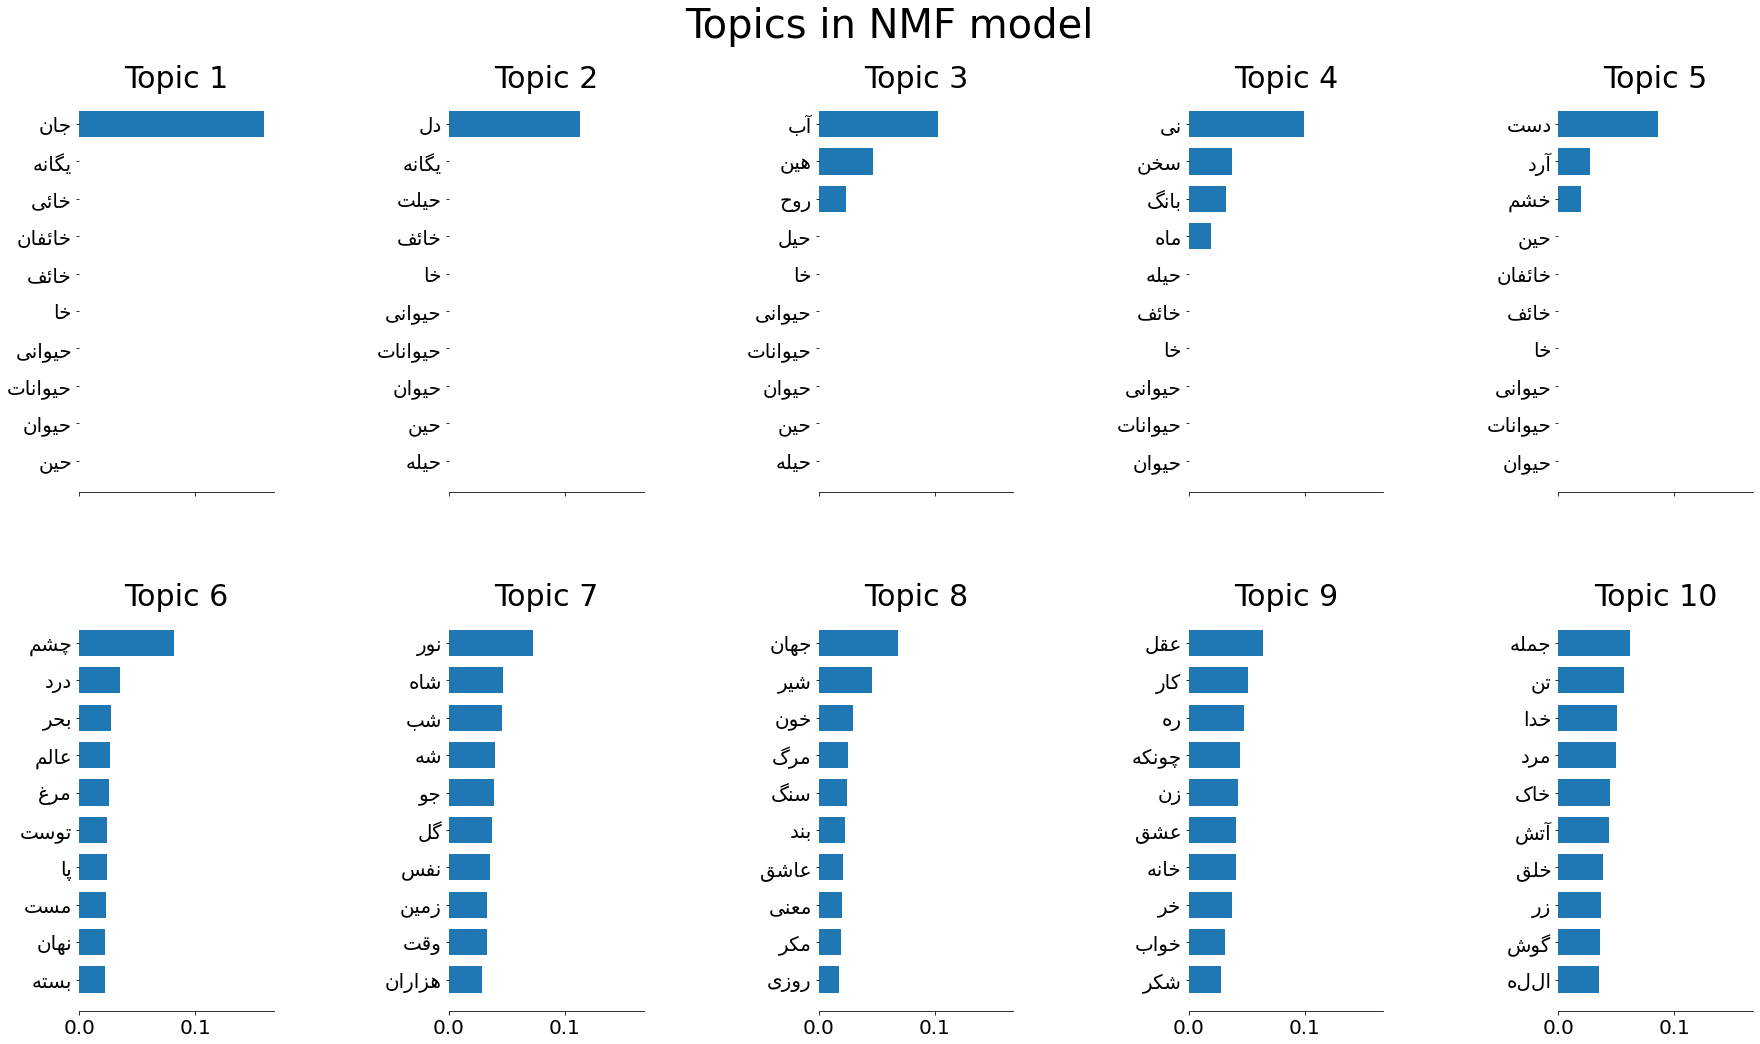

In [151]:
plot_top_words(
    nmf,
    tfidf_feature_names,
    10,
    "Topics in NMF model",
)

In [137]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [138]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [139]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [140]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [141]:
top_words = 10

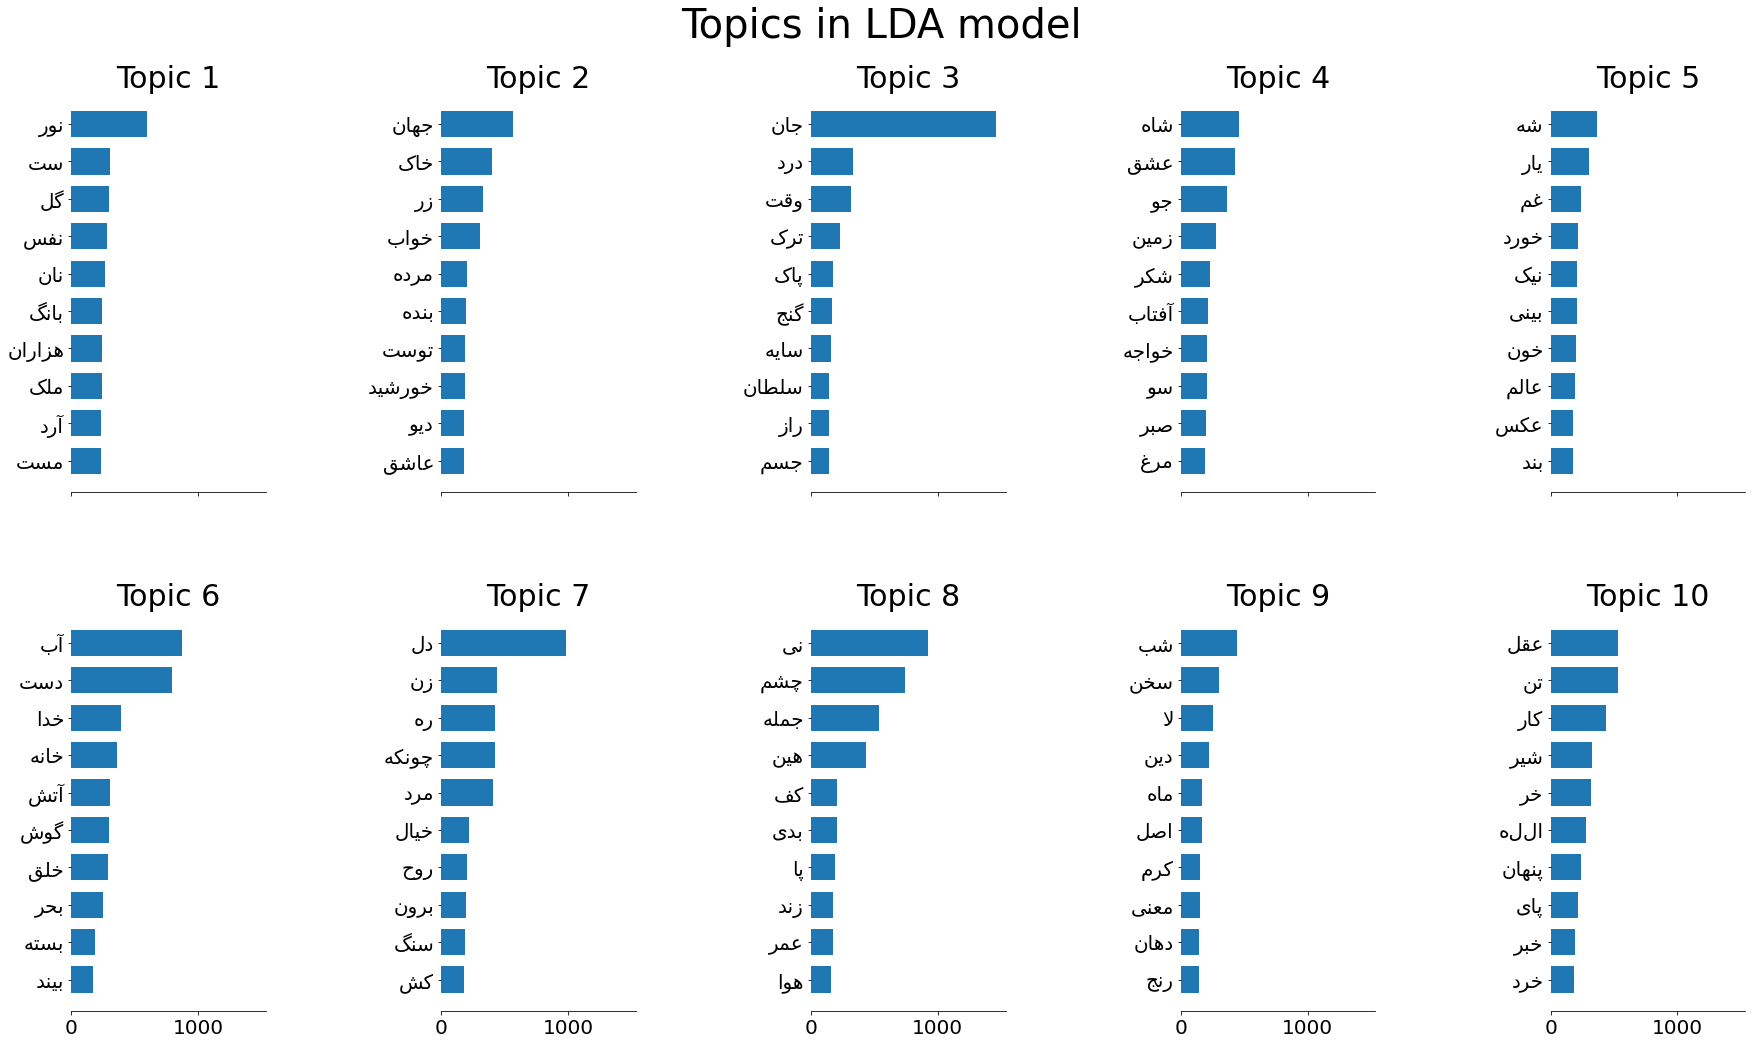

In [142]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")

### Plot frequent words by Daftar

In [153]:
freq_df = pd.DataFrame(columns=['index', 'Freq', 'Daftar'])
for i in range(1,7):
    freq_dict = nltk.FreqDist(chain(*masnavi_df[masnavi_df['Daftar'] == i]['Couplet_tokenized']))
    freq_dict = pd.DataFrame.from_dict(freq_dict, orient='index', columns=['Freq'])
    freq_dict['Daftar'] = [i] * freq_dict.shape[0]
    freq_dict.reset_index(level=0, inplace=True)
    freq_dict['index'] = freq_dict['index'].apply(lambda x: make_farsi_text(x))
    freq_df = pd.concat([freq_df, freq_dict])

In [154]:
freq_df = freq_df[freq_df['Freq']> 100]

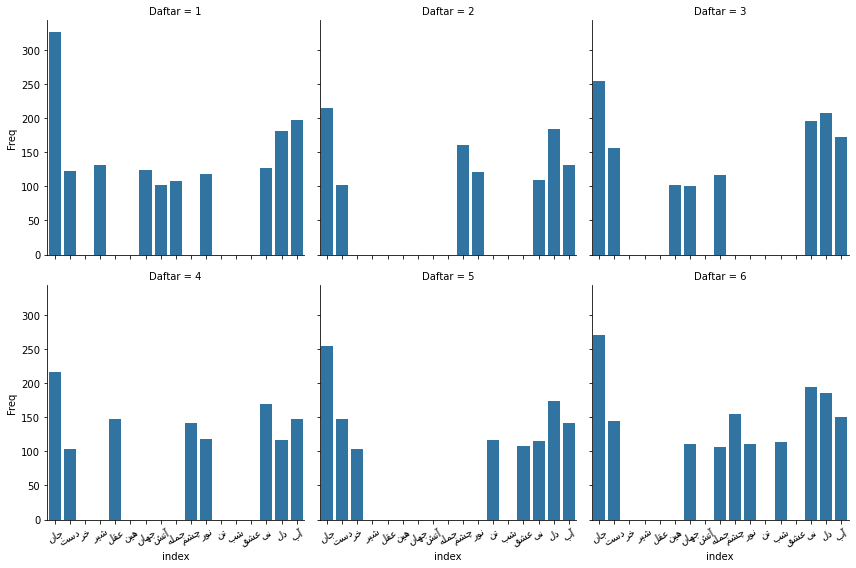

In [155]:
g = sns.FacetGrid(freq_df, col="Daftar", height=4, aspect=1, col_wrap=3)
g.set_xticklabels(rotation=30)
g.map(sns.barplot, "index", "Freq", order=list(set(freq_df['index'])))

### Topic Modeling

In [156]:
from gensim.test.utils import datapath
from pprint import pprint

In [157]:
dp_groups = masnavi_df.groupby(['Daftar'])

In [171]:
poems = []
for name, group in dp_groups:
    poems.append([t for l in group['Couplet_tokenized'] for t in l])

In [190]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [191]:
tf = tf_vectorizer.fit_transform(poems[1])

In [192]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [193]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [194]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [195]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [196]:
top_words = 10

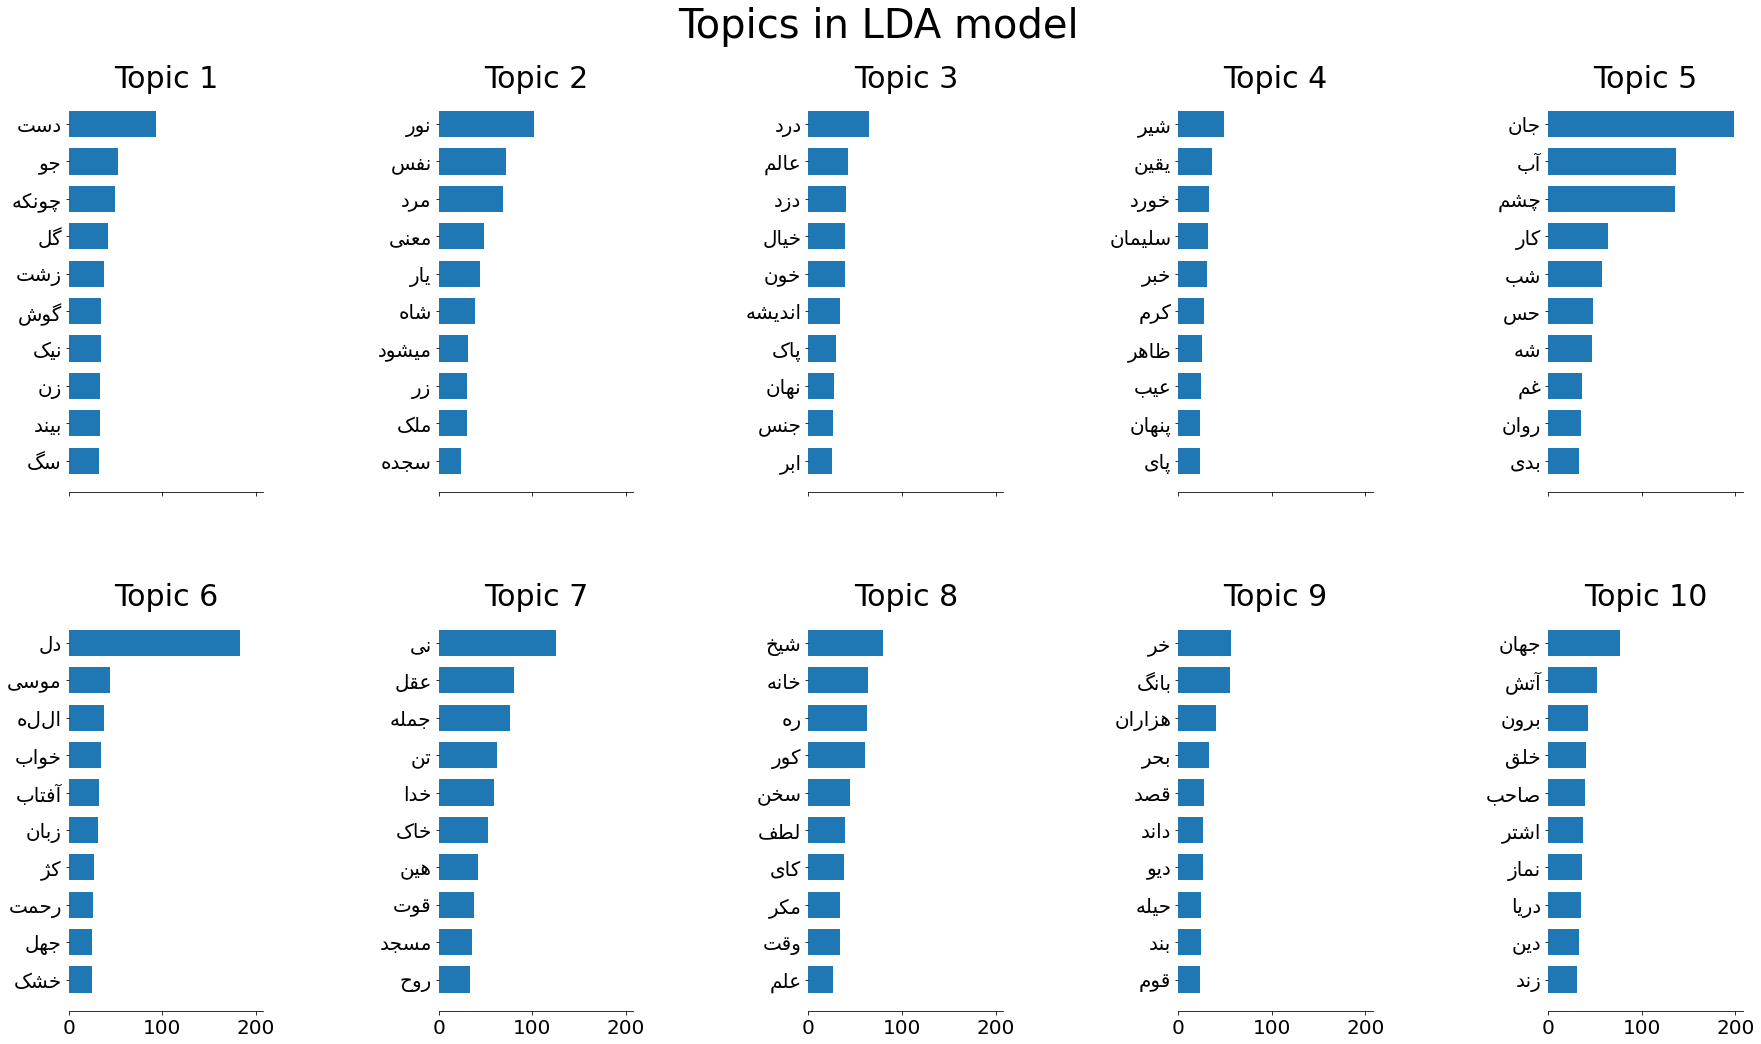

In [197]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")